# Electricity Load forecasting using RNNs. 

## Project Done by:

### Shaik Azharuddin (AM19M016)

In [31]:
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras import layers
from tensorflow.keras.optimizers import RMSprop
from xgboost import XGBRegressor
import tensorflow as tf
plt.style.use('ggplot')

## **importing data**

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
core_dir = "/content/drive/MyDrive/assignment-data.csv"

In [5]:
data = pd.read_csv(core_dir)

In [6]:
len(data)

103392

In [7]:
data.tail(2)

,Unnamed: 0,datetime,load,apparent_temperature,temperature,humidity,dew_point,wind_speed,cloud_cover,date
103390,103390,2020-12-12 23:30:00,763.56,17.27250,17.27250,0.761250,11.9910,2.241750,0.0840,2020-12-12
103391,103391,2020-12-12 23:45:00,734.27,17.07825,17.07825,0.763875,11.8545,2.338875,0.0525,2020-12-12


In [8]:
len(data[data['date']=="2020-12-12"])  # (24*60)/15 == 96 instances per day

96

In [9]:
data.isnull().sum()

Unnamed: 0                 0
datetime                   0
load                    1440
apparent_temperature       0
temperature                0
humidity                   0
dew_point                  0
wind_speed                 0
cloud_cover                0
date                       0
dtype: int64

In [10]:
data_with_load_nan = data[data['load'].isnull()]

In [11]:
len(data_with_load_nan)

1440

In [12]:
data_with_load_nan.tail(2)

,Unnamed: 0,datetime,load,apparent_temperature,temperature,humidity,dew_point,wind_speed,cloud_cover,date
97054,97054,2020-10-07 23:30:00,NaN,29.4000,28.3500,0.3045,12.0750,1.05,0.0,2020-10-07
97055,97055,2020-10-07 23:45:00,NaN,29.1375,28.0875,0.3150,12.2325,1.05,0.0,2020-10-07


In [13]:
data_with_load_nan['date'].unique()        # loads corresponding to 15 dates are missing ==> 15*96 = 1440 instances

array(['2019-05-16', '2019-05-17', '2019-05-18', '2019-05-19',
       '2019-07-15', '2019-07-16', '2019-07-17', '2019-07-18',
       '2019-10-27', '2019-12-31', '2020-01-01', '2020-03-22',
       '2020-10-05', '2020-10-06', '2020-10-07'], dtype=object)

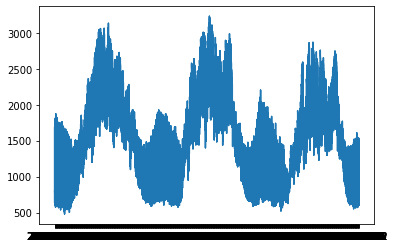

In [14]:
import matplotlib.pyplot as plt

plt.plot(data['date'],data['load'])

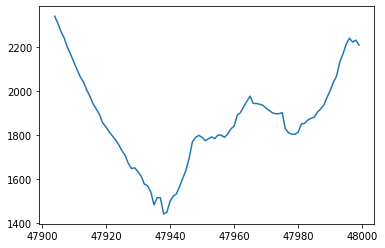

In [16]:
plt.plot(data['load'][(48000-96):48096])

In [17]:
def fill_previous_days_value(dataset):
    n = len(dataset)
    old_loads = list(dataset['load'])
    #loads = []
    for i in range(n):
        if str(old_loads[i]) == 'nan':
            old_loads[i] = old_loads[i-96]
    dataset['load'] = old_loads

In [18]:
data_copy = data.copy()
data_with_load_nan_copy = data_with_load_nan.copy()

In [19]:
fill_previous_days_value(data_copy)

In [20]:
data_copy.isnull().sum()

Unnamed: 0              0
datetime                0
load                    0
apparent_temperature    0
temperature             0
humidity                0
dew_point               0
wind_speed              0
cloud_cover             0
date                    0
dtype: int64

In [21]:
raw_data = np.array(data_copy.iloc[:,[2,4,5,6,7,8]])
loads = np.array(data_copy.iloc[:,2])
print(raw_data.shape)
print(loads.shape)

(103392, 6)
(103392,)


Computing the number of samples we'll use for each data split


In [22]:
num_train_samples = int(0.5 * len(raw_data))
num_val_samples = int(0.25 * len(raw_data))
num_test_samples = len(raw_data) - num_train_samples - num_val_samples
print("num_train_samples:", num_train_samples)
print("num_val_samples:", num_val_samples)
print("num_test_samples:", num_test_samples)

num_train_samples: 51696
num_val_samples: 25848
num_test_samples: 25848


Normalisig the data

In [23]:
mean = raw_data[:num_train_samples].mean(axis=0)
raw_data -= mean
std = raw_data[:num_train_samples].std(axis=0)
raw_data /= std

**[Generator yielding timeseries samples and thier targets]**

In [24]:
def generator(data, lookback, delay, min_index, max_index,
              shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)
        samples = np.zeros((len(rows), lookback // step, data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][0]
        yield samples, targets

In [25]:
lookback = 960
step = 6
delay = 192
batch_size = 128     # 960/6 == 160

train_gen = generator(raw_data,
                        lookback=lookback,
                        delay=delay,
                        min_index=0,
                        max_index=num_train_samples-1,
                        shuffle=True,
                        step=step,
                        batch_size=batch_size)
val_gen = generator(raw_data, 
                    lookback=lookback,
                    delay=delay,
                    min_index=num_train_samples,
                    max_index=num_train_samples+num_val_samples-1,
                    step=step,
                    batch_size=batch_size)
test_gen = generator(raw_data, 
                     lookback=lookback,
                     delay=delay,
                     min_index=num_train_samples+num_val_samples,
                     max_index=num_train_samples+num_val_samples+num_test_samples-1-delay,
                     step=step,
                     batch_size=batch_size)

val_steps = (num_val_samples - lookback) // batch_size

test_steps = (num_test_samples -1 -delay - lookback) // batch_size

In [26]:
for samples, targets in train_gen:
    print("samples shape:", samples.shape)
    print("targets shape:", targets.shape)
    break

samples shape: (128, 160, 6)
targets shape: (128,)


In [27]:
def evaluate_naive_method():
    batch_maes = []
    for step in range(val_steps):
        samples, targets = next(val_gen)
        preds =  samples[:, -1, 0] 
        mae = np.mean(np.abs(preds - targets))
        batch_maes.append(mae)
    print(np.mean(batch_maes))
    return preds,targets,batch_maes
preds,targets,batch_maes = evaluate_naive_method()

0.3171407351507706


In [28]:
load_mae = (np.mean(batch_maes) * std[0]) 
print(load_mae)

169.73303903229703


## **Traning a densely connected model**

In [ ]:
from keras.models import Sequential
from keras import layers
from tensorflow.keras.optimizers import RMSprop
model = Sequential()
model.add(layers.Flatten(input_shape=(lookback // step, raw_data.shape[-1])))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1))
model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                                steps_per_epoch=500,
                                epochs=20,
                                validation_data=val_gen,
                                validation_steps=val_steps)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
500/500 [==============================] - 8s 15ms/step - loss: 0.4826 - val_loss: 0.3121
Epoch 2/20
500/500 [==============================] - 6s 12ms/step - loss: 0.2694 - val_loss: 0.2459
Epoch 3/20
500/500 [==============================] - 7s 15ms/step - loss: 0.2113 - val_loss: 0.2331
Epoch 4/20
500/500 [==============================] - 7s 14ms/step - loss: 0.1774 - val_loss: 0.2773
Epoch 5/20
500/500 [==============================] - 7s 15ms/step - loss: 0.1594 - val_loss: 0.2416
Epoch 6/20
500/500 [==============================] - 7s 15ms/step - loss: 0.1449 - val_loss: 0.2518
Epoch 7/20
500/500 [==============================] - 7s 15ms/step - loss: 0.1353 - val_loss: 0.2471
Epoch 8/20
500/500 [==============================] - 7s 14ms/step - loss: 0.1279 - val_loss: 0.2776
Epoch 9/20
500/500 [==============================] - 7s 15ms/step - loss: 0.1216 - val_loss: 0.2637
Epoch 10/20
500/500 [==============================] - 7s 15ms/step - loss: 0.1163 - val_lo

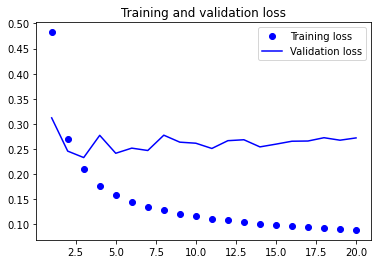

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

**Traning and evaluating a GRU based model**

In [ ]:
from keras.models import Sequential
from keras import layers
from tensorflow.keras.optimizers import RMSprop
model = Sequential()
model.add(layers.GRU(32, input_shape=(None, raw_data.shape[-1])))
model.add(layers.Dense(1))
model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                steps_per_epoch=500,
                epochs=20,
                validation_data=val_gen,
                validation_steps=val_steps)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
500/500 [==============================] - 51s 98ms/step - loss: 0.2814 - val_loss: 0.2389
Epoch 2/20
500/500 [==============================] - 49s 98ms/step - loss: 0.2283 - val_loss: 0.2294
Epoch 3/20
500/500 [==============================] - 48s 97ms/step - loss: 0.2085 - val_loss: 0.2465
Epoch 4/20
500/500 [==============================] - 49s 98ms/step - loss: 0.1950 - val_loss: 0.2427
Epoch 5/20
500/500 [==============================] - 49s 97ms/step - loss: 0.1862 - val_loss: 0.2506
Epoch 6/20
500/500 [==============================] - 49s 99ms/step - loss: 0.1792 - val_loss: 0.2506
Epoch 7/20
500/500 [==============================] - 49s 98ms/step - loss: 0.1702 - val_loss: 0.2545
Epoch 8/20
500/500 [==============================] - 49s 98ms/step - loss: 0.1637 - val_loss: 0.2561
Epoch 9/20
500/500 [==============================] - 49s 98ms/step - loss: 0.1577 - val_loss: 0.2541
Epoch 10/20
500/500 [==============================] - 48s 97ms/step - loss: 0.151

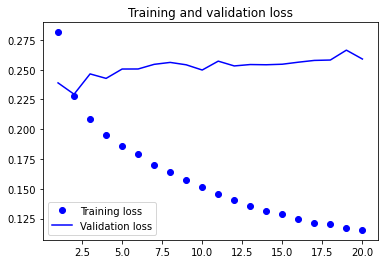

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

**Training and evaluating a dropout-regularized GRU-based model**

In [ ]:
from keras.models import Sequential
from keras import layers
from tensorflow.keras.optimizers import RMSprop
model = Sequential()
model.add(layers.GRU(32,
                    dropout=0.2,
                    recurrent_dropout=0.2,
                    input_shape=(None, raw_data.shape[-1])))
model.add(layers.Dense(1))
model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,steps_per_epoch=500,
                                epochs=8,
                                validation_data=val_gen,
                                validation_steps=val_steps)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/8
500/500 [==============================] - 90s 175ms/step - loss: 0.3644 - val_loss: 0.2747
Epoch 2/8
500/500 [==============================] - 88s 176ms/step - loss: 0.2901 - val_loss: 0.2477
Epoch 3/8
500/500 [==============================] - 88s 175ms/step - loss: 0.2627 - val_loss: 0.2263
Epoch 4/8
500/500 [==============================] - 88s 177ms/step - loss: 0.2451 - val_loss: 0.2174
Epoch 5/8
500/500 [==============================] - 88s 175ms/step - loss: 0.2321 - val_loss: 0.2163
Epoch 6/8
500/500 [==============================] - 87s 174ms/step - loss: 0.2256 - val_loss: 0.2140
Epoch 7/8
500/500 [==============================] - 87s 174ms/step - loss: 0.2165 - val_loss: 0.2183
Epoch 8/8
500/500 [==============================] - 87s 174ms/step - loss: 0.2120 - val_loss: 0.2295


In [ ]:
model.save('/content/drive/MyDrive/dropout_1GRU.h5') 

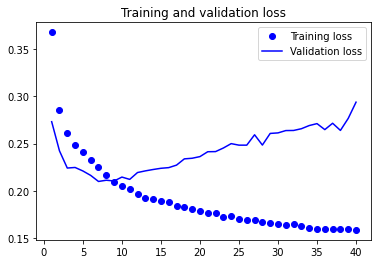

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [ ]:
(0.21 * std[0]) 

112.39154812401199

**Drop out regularised stacked GRU model**

In [ ]:
model = Sequential()

model.add(layers.GRU(32,
                        dropout=0.1,
                        recurrent_dropout=0.5,
                        return_sequences=True,
                        input_shape=(None, raw_data.shape[-1])))
model.add(layers.GRU(64, activation='relu',
                        dropout=0.1,
                        recurrent_dropout=0.5))
model.add(layers.Dense(1))
model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
steps_per_epoch=500,
epochs=40,
validation_data=val_gen,
validation_steps=val_steps)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/40
500/500 [==============================] - 280s 549ms/step - loss: 0.3444 - val_loss: 0.2639
Epoch 2/40
500/500 [==============================] - 259s 517ms/step - loss: 0.2767 - val_loss: 0.2381
Epoch 3/40
500/500 [==============================] - 257s 514ms/step - loss: 0.2502 - val_loss: 0.2249
Epoch 4/40
500/500 [==============================] - 258s 516ms/step - loss: 0.2327 - val_loss: 0.2195
Epoch 5/40
500/500 [==============================] - 258s 516ms/step - loss: 0.2223 - val_loss: 0.2283
Epoch 6/40
500/500 [==============================] - 258s 515ms/step - loss: 0.2134 - val_loss: 0.2377
Epoch 7/40
500/500 [==============================] - 258s 515ms/step - loss: 0.2057 - val_loss: 0.2274
Epoch 8/40
500/500 [==============================] - 258s 515ms/step - loss: 0.1998 - val_loss: 0.2377
Epoch 9/40
500/500 [==============================] - 258s 516ms/step - loss: 0.1944 - val_loss: 0.2468
Epoch 10/40
500/500 [==============================] - 258s 516m

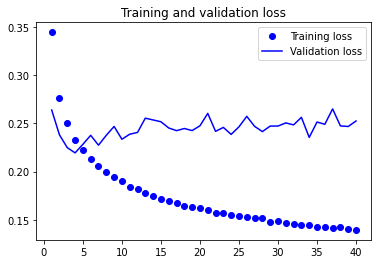

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

## **using bi directional GRU**

In [ ]:
def generator_1(data, lookback, delay, min_index, max_index,
              shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)
        samples = np.zeros((len(rows), lookback // step, data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][0]
        yield samples[:, ::-1, :], targets

In [ ]:
train_gen_1 = generator_1(raw_data,
                        lookback=lookback,
                        delay=delay,
                        min_index=0,
                        max_index=num_train_samples-1,
                        shuffle=True,
                        step=step,
                        batch_size=batch_size)
val_gen_1 = generator_1(raw_data, 
                    lookback=lookback,
                    delay=delay,
                    min_index=num_train_samples,
                    max_index=num_train_samples+num_val_samples-1,
                    step=step,
                    batch_size=batch_size)
test_gen_1 = generator_1(raw_data, 
                     lookback=lookback,
                     delay=delay,
                     min_index=num_train_samples+num_val_samples,
                     max_index=num_train_samples+num_val_samples+num_test_samples-1,
                     step=step,
                     batch_size=batch_size)

In [ ]:
model = Sequential()
model.add(layers.GRU(32,
                    dropout=0.2,
                    recurrent_dropout=0.2,
                    input_shape=(None, raw_data.shape[-1])))
model.add(layers.Dense(1))
model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen_1,steps_per_epoch=500,
                                epochs=40,
                                validation_data=val_gen_1,
                                validation_steps=val_steps)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/40
500/500 [==============================] - 94s 182ms/step - loss: 0.3764 - val_loss: 0.3332
Epoch 2/40
500/500 [==============================] - 91s 183ms/step - loss: 0.3165 - val_loss: 0.3227
Epoch 3/40
500/500 [==============================] - 90s 181ms/step - loss: 0.2813 - val_loss: 0.3080
Epoch 4/40
500/500 [==============================] - 90s 179ms/step - loss: 0.2567 - val_loss: 0.2991
Epoch 5/40
500/500 [==============================] - 89s 179ms/step - loss: 0.2436 - val_loss: 0.3079
Epoch 6/40
500/500 [==============================] - 89s 179ms/step - loss: 0.2340 - val_loss: 0.2922
Epoch 7/40
500/500 [==============================] - 89s 178ms/step - loss: 0.2259 - val_loss: 0.3005
Epoch 8/40
500/500 [==============================] - 89s 179ms/step - loss: 0.2181 - val_loss: 0.2969
Epoch 9/40
500/500 [==============================] - 89s 179ms/step - loss: 0.2140 - val_loss: 0.2990
Epoch 10/40
500/500 [==============================] - 89s 178ms/step - l

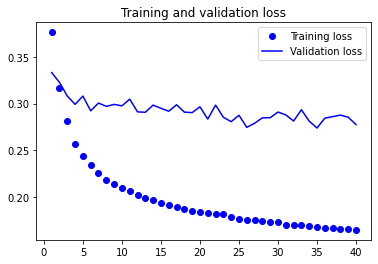

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

### **Drop regularised single layered lstm model**

In [ ]:
model = Sequential()
model.add(layers.LSTM(32,
                    dropout=0.2,
                    recurrent_dropout=0.2,
                    input_shape=(None, raw_data.shape[-1])))
model.add(layers.Dense(1))
model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,steps_per_epoch=500,
                                epochs=40,
                                validation_data=val_gen,
                                validation_steps=val_steps)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/40
500/500 [==============================] - 105s 205ms/step - loss: 0.3414 - val_loss: 0.2578
Epoch 2/40
500/500 [==============================] - 103s 205ms/step - loss: 0.2597 - val_loss: 0.2328
Epoch 3/40
500/500 [==============================] - 103s 206ms/step - loss: 0.2396 - val_loss: 0.2303
Epoch 4/40
500/500 [==============================] - 103s 206ms/step - loss: 0.2241 - val_loss: 0.2381
Epoch 5/40
500/500 [==============================] - 103s 207ms/step - loss: 0.2089 - val_loss: 0.2356
Epoch 6/40
500/500 [==============================] - 103s 206ms/step - loss: 0.1966 - val_loss: 0.2498
Epoch 7/40
500/500 [==============================] - 103s 206ms/step - loss: 0.1892 - val_loss: 0.2382
Epoch 8/40
500/500 [==============================] - 103s 207ms/step - loss: 0.1824 - val_loss: 0.2561
Epoch 9/40
500/500 [==============================] - 103s 206ms/step - loss: 0.1790 - val_loss: 0.2428
Epoch 10/40
500/500 [==============================] - 104s 208m

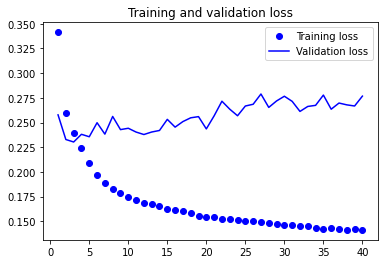

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

## Best model as of now!!

(128,) (128,)
test_mae 0.48632200593692404


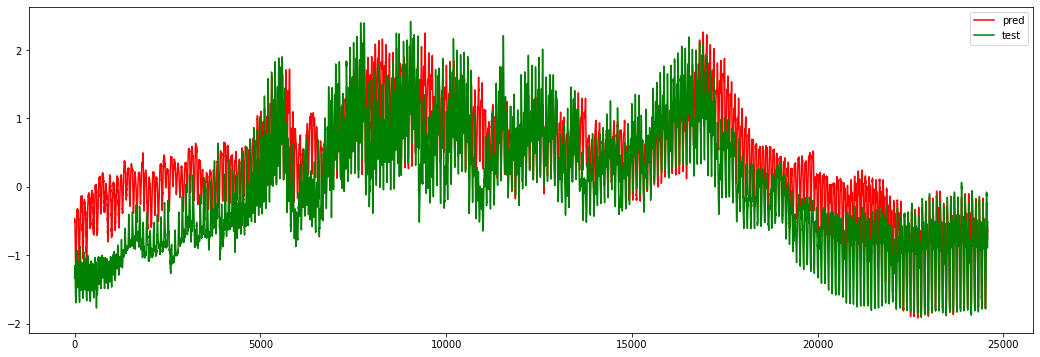

In [29]:
best_model = tf.keras.models.load_model('/content/drive/MyDrive/dropout_1GRU.h5')
batch_maes = []
pred = []
true = []
# for samples, targets in test_gen:
for i in range(test_steps):
    # if i == 191:
    #     break
    samples, targets = next(test_gen)
    preds =  best_model.predict(samples)
    preds = preds.T[0]
    #if i==0:
     #   print(preds.shape,targets.shape)
    pred += list(preds)
    true += list(targets)  
    mae = np.mean(np.abs(preds - targets))
    batch_maes.append(mae)

print('test_mae', np.mean(batch_maes))
plt.figure(figsize=(18, 6))
plt.plot(np.array(pred), color='r', label='pred')
plt.plot(np.array(true), color='g', label='test')
plt.legend()
plt.show()

## **Predicting using Xgboost**

Distribution of electricity load consumption: 

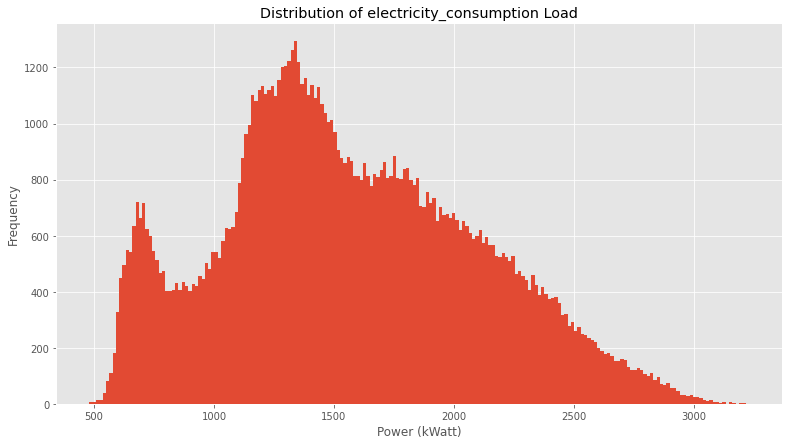

In [32]:
_ = data_copy['load'].plot.hist(figsize=(13, 7), bins=200, title='Distribution of electricity_consumption Load')
plt.xlabel('Power (kWatt)')
plt.show()

In [33]:
data_cc = data_copy.copy()
data_cc_timestamp = pd.to_datetime(data_cc['datetime'])
data_cc = (data_cc.assign(day_of_week = data_cc_timestamp.dt.dayofweek,
                year = data_cc_timestamp.dt.year,
                month = data_cc_timestamp.dt.month,
                day = data_cc_timestamp.dt.day, 
                week = data_cc_timestamp.dt.week,
                week_day = data_cc_timestamp.dt.day_name(), 
                quarter = data_cc_timestamp.dt.quarter,
                hour = data_cc_timestamp.dt.hour))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  import sys


**Winter Energy Consumption:**

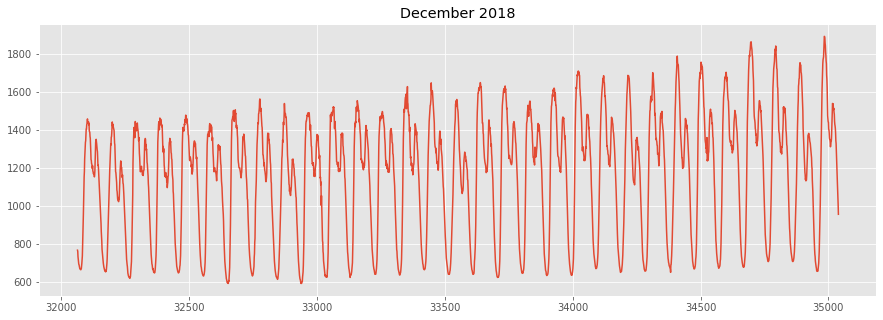

In [34]:
_ = (data_cc['load'].loc[ (data_cc['date'] >= '2018-12-01') &
                                        (data_cc['date']  < '2019-01-01') ] 
                                        .plot(figsize=(15, 5), title = 'December 2018'))
plt.show()

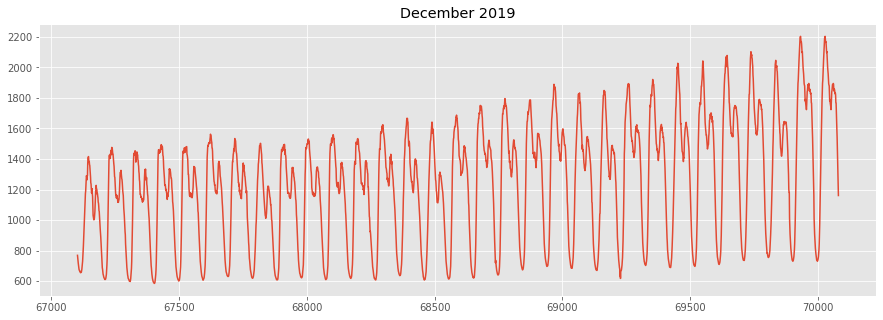

In [35]:
_ = (data_cc['load'].loc[ (data_cc['date'] >= '2019-12-01') &
                                        (data_cc['date']  < '2020-01-01') ] 
                                        .plot(figsize=(15, 5), title = 'December 2019'))
plt.show()

**Summer Energy Consumption:**

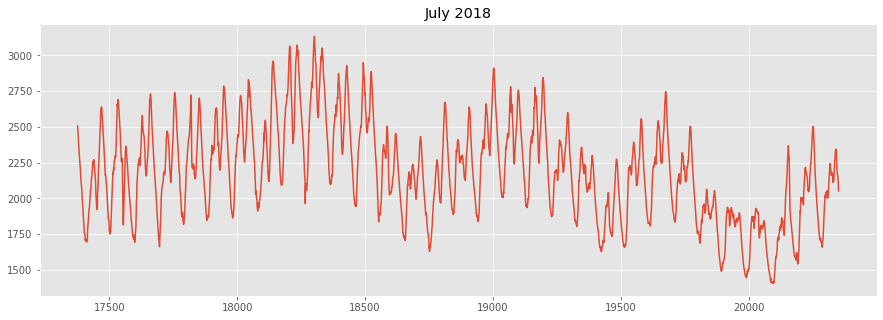

In [36]:
# Summer consumption
_ = (data_cc['load'].loc[ (data_cc['date'] >= '2018-07-01') &
                                        (data_cc['date']  < '2018-08-01') ] 
                                        .plot(figsize=(15, 5), title = 'July 2018'))
plt.show()

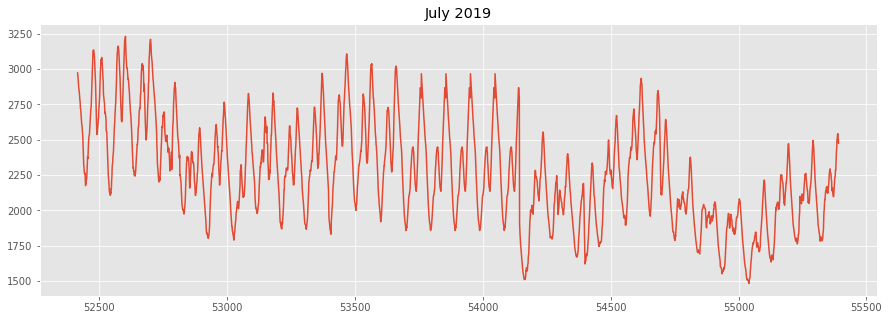

In [37]:
_ = (data_cc['load'].loc[ (data_cc['date'] >= '2019-07-01') &
                                        (data_cc['date']  < '2019-08-01') ] 
                                        .plot(figsize=(15, 5), title = 'July 2019'))
plt.show()

## **Daily trends**

## **Wind speed**

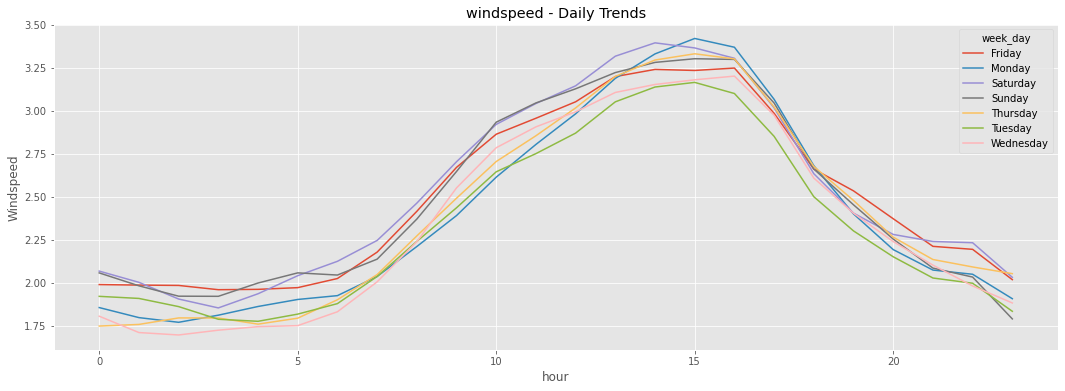

In [38]:
_ = data_cc.pivot_table(index   = data_cc['hour'], 
                   columns = 'week_day', 
                   values  = 'wind_speed',
                   aggfunc = 'mean').plot(figsize=(18,6),
                   title   = 'windspeed - Daily Trends')
plt.ylabel('Windspeed')
plt.show()

## **Due point**

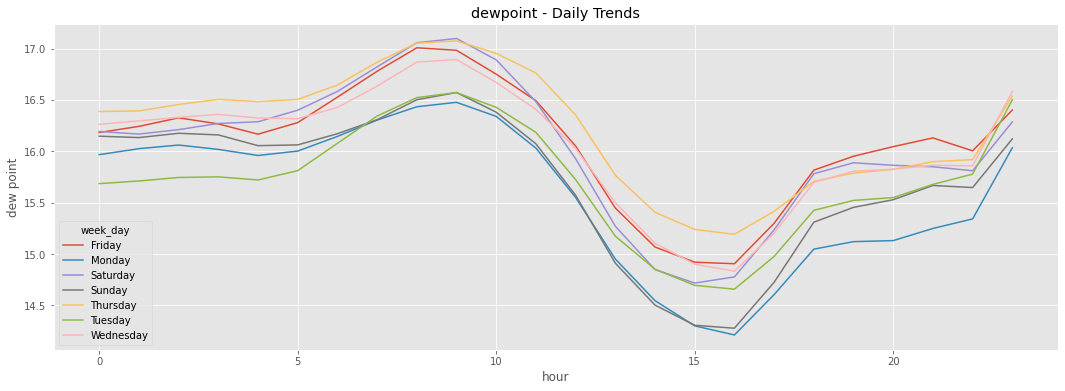

In [ ]:
_ = data_cc.pivot_table(index   = data_cc['hour'], 
                   columns = 'week_day', 
                   values  = 'dew_point',
                   aggfunc = 'mean').plot(figsize=(18,6),
                   title   = 'dewpoint - Daily Trends')
plt.ylabel('dew point')
plt.show()

## **^Temperature**

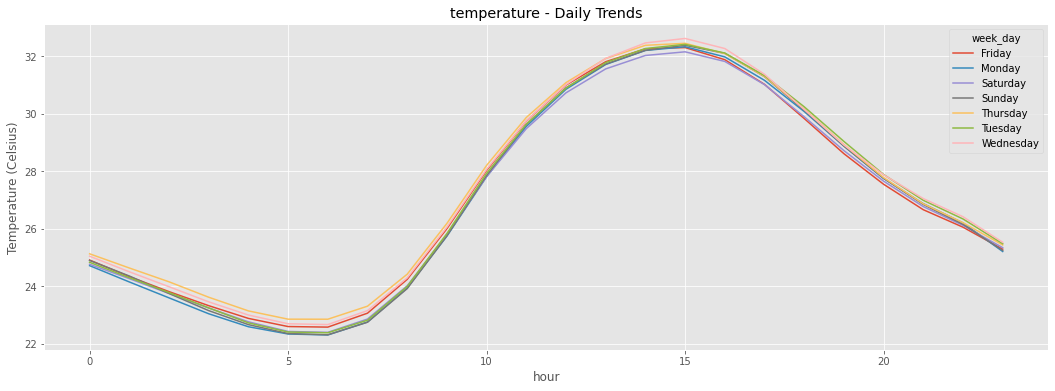

In [ ]:
_ = data_cc.pivot_table(index   = data_cc['hour'], 
                   columns = 'week_day', 
                   values  = 'temperature',
                   aggfunc = 'mean').plot(figsize=(18,6),
                   title   = 'temperature - Daily Trends')
plt.ylabel('Temperature (Celsius)')
plt.show()

## **Cloud COver**

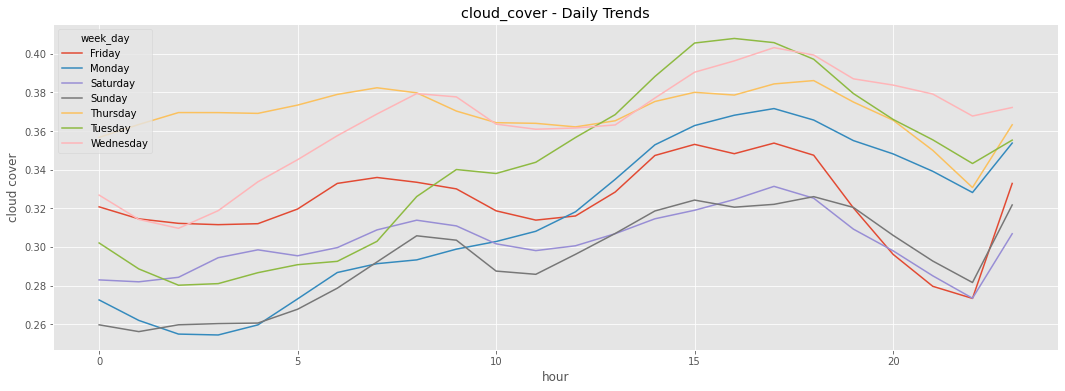

In [ ]:
_ = data_cc.pivot_table(index   = data_cc['hour'], 
                   columns = 'week_day', 
                   values  = 'cloud_cover',
                   aggfunc = 'mean').plot(figsize=(18,6),
                   title   = 'cloud_cover - Daily Trends')
plt.ylabel('cloud cover')
plt.show()

## **humidity**

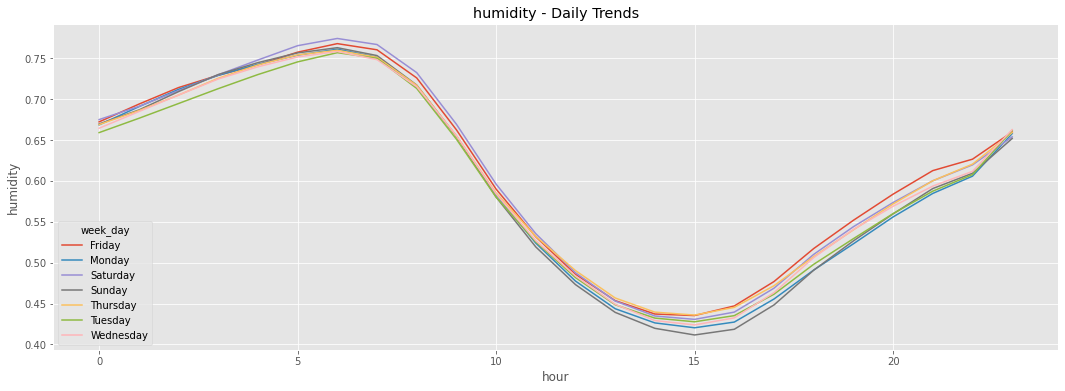

In [ ]:
_ = data_cc.pivot_table(index   = data_cc['hour'], 
                   columns = 'week_day', 
                   values  = 'humidity',
                   aggfunc = 'mean').plot(figsize=(18,6),
                   title   = 'humidity - Daily Trends')
plt.ylabel('humidity')
plt.show()

# **Electricity consumption**

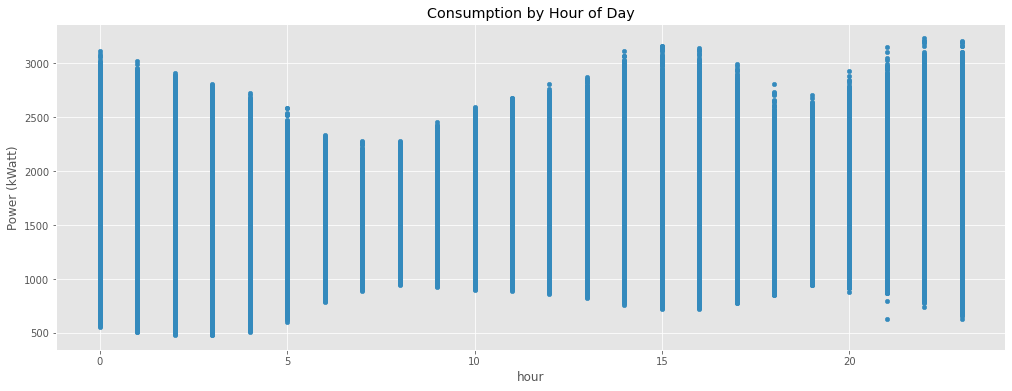

In [ ]:
_ = data_cc[['load','hour']].plot(x = 'hour',
                                                y ='load',
                                                kind = 'scatter',
                                                figsize = (17,6),
                                                title = 'Consumption by Hour of Day')
plt.ylabel('Power (kWatt)')
plt.show()

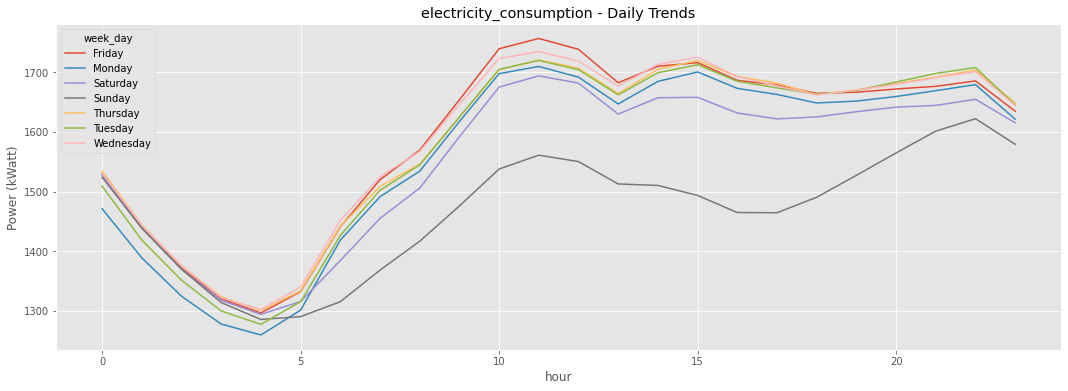

In [ ]:
_ = data_cc.pivot_table(index   = data_cc['hour'], 
                   columns = 'week_day', 
                   values  = 'load',
                   aggfunc = 'mean').plot(figsize=(18,6),
                   title   = 'electricity_consumption - Daily Trends')
plt.ylabel('Power (kWatt)')
plt.show()

## **Yearly Trends**

## **Electricity consumption**

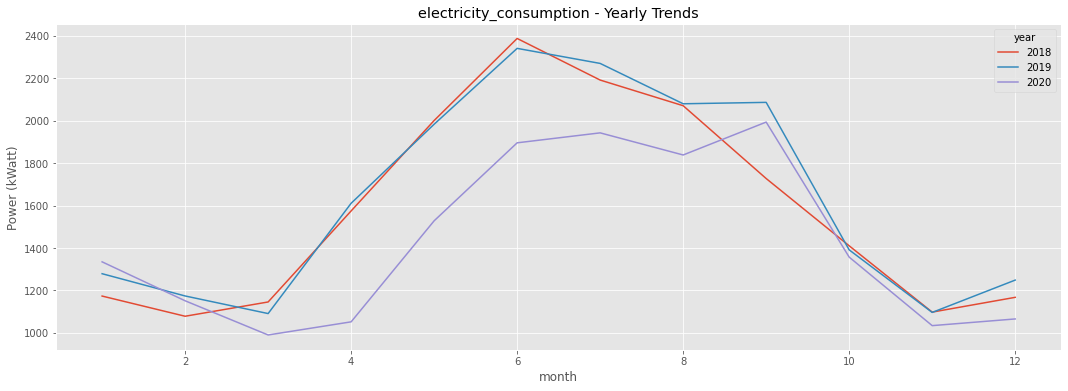

In [ ]:
_ = data_cc.pivot_table(index   = data_cc['month'], 
                   columns = 'year', 
                   values  = 'load',
                   aggfunc = 'mean').plot(figsize = (18,6),
                                          title   = 'electricity_consumption - Yearly Trends')
plt.ylabel('Power (kWatt)')
plt.show()


## **Wind speed**

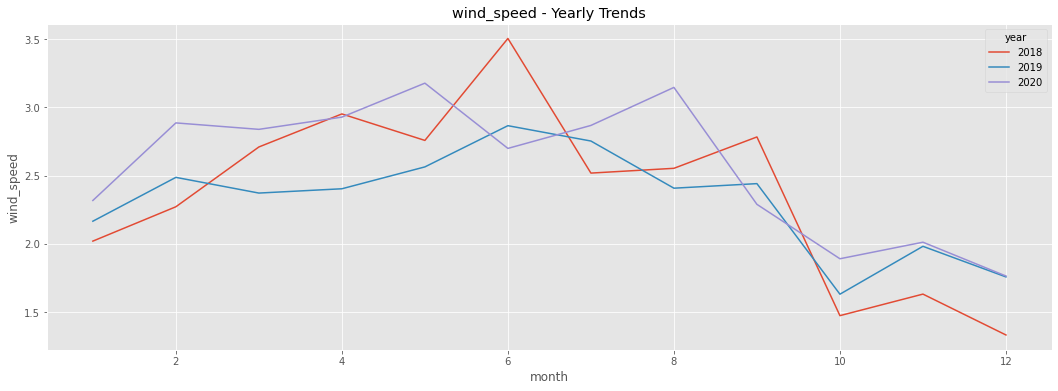

In [ ]:
_ = data_cc.pivot_table(index   = data_cc['month'], 
                   columns = 'year', 
                   values  = 'wind_speed',
                   aggfunc = 'mean').plot(figsize = (18,6),
                                          title   = 'wind_speed - Yearly Trends')
plt.ylabel('wind_speed')
plt.show()

## **Dew point**

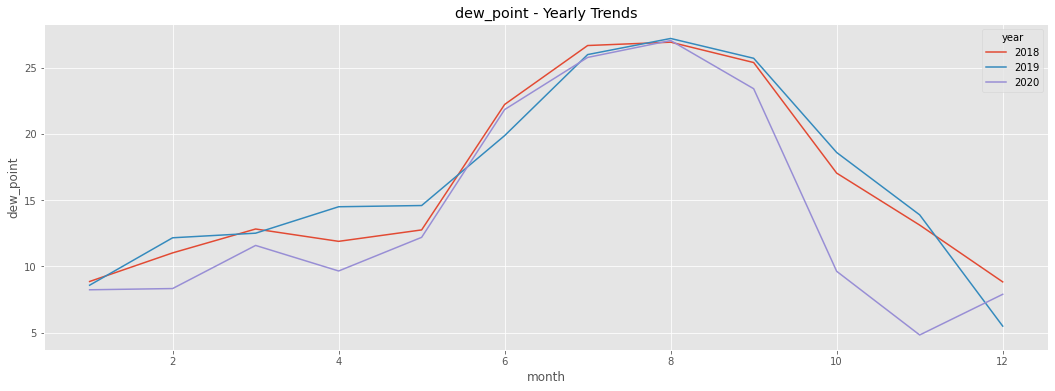

In [ ]:
_ = data_cc.pivot_table(index   = data_cc['month'], 
                   columns = 'year', 
                   values  = 'dew_point',
                   aggfunc = 'mean').plot(figsize = (18,6),
                                          title   = 'dew_point - Yearly Trends')
plt.ylabel('dew_point')
plt.show()

## **Temperature**

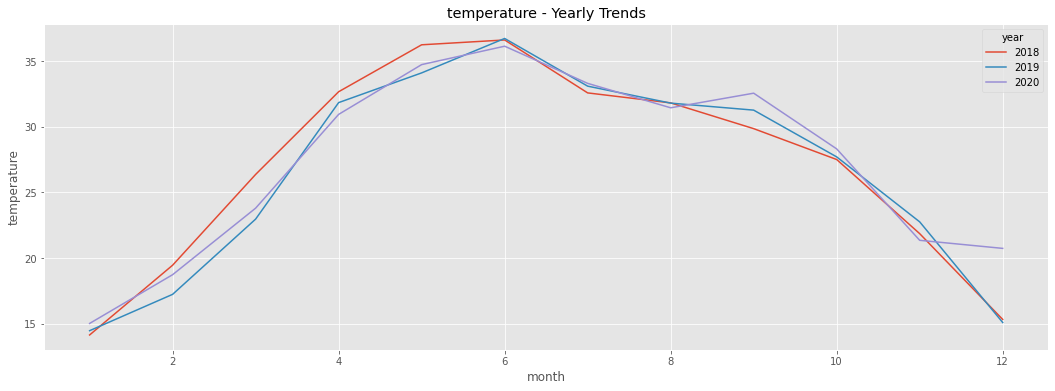

In [ ]:
_ = data_cc.pivot_table(index   = data_cc['month'], 
                   columns = 'year', 
                   values  = 'temperature',
                   aggfunc = 'mean').plot(figsize = (18,6),
                                          title   = 'temperature - Yearly Trends')
plt.ylabel('temperature')
plt.show()

## **Cloud cover**

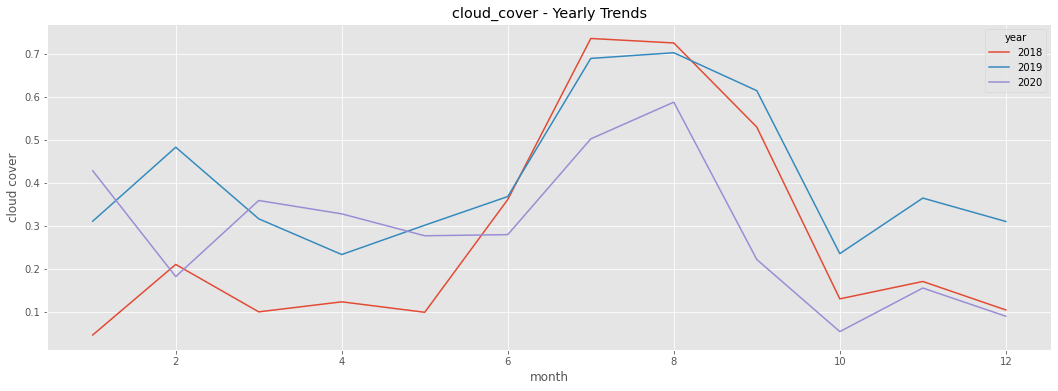

In [ ]:
_ = data_cc.pivot_table(index   = data_cc['month'], 
                   columns = 'year', 
                   values  = 'cloud_cover',
                   aggfunc = 'mean').plot(figsize = (18,6),
                                          title   = 'cloud_cover - Yearly Trends')
plt.ylabel('cloud cover')
plt.show()

## **Humidity**

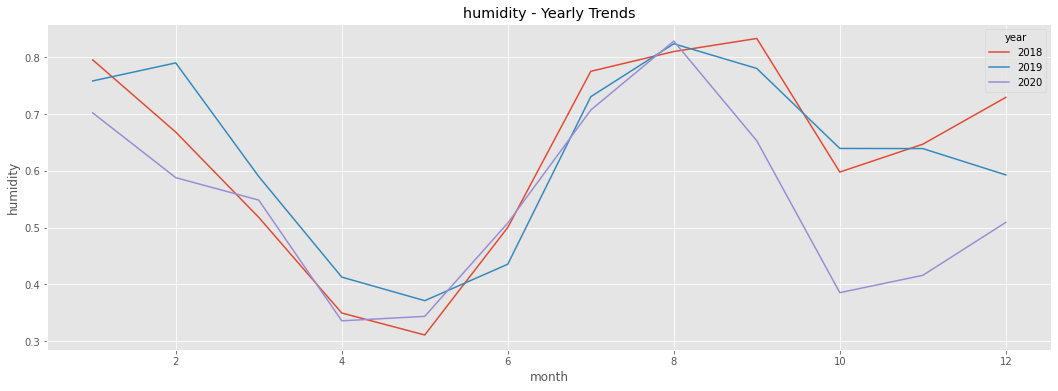

In [ ]:
_ = data_cc.pivot_table(index   = data_cc['month'], 
                   columns = 'year', 
                   values  = 'humidity',
                   aggfunc = 'mean').plot(figsize = (18,6),
                                          title   = 'humidity - Yearly Trends')
plt.ylabel('humidity')
plt.show()

## **model building**

In [39]:
data_new = data_copy.loc[:,['load','temperature','humidity','dew_point','wind_speed','cloud_cover']]
cols = ['load', 'temperature', 'humidity', 'dew_point', 'wind_speed', 'cloud_cover']
from sklearn.preprocessing import StandardScaler
data_new[cols] = StandardScaler().fit_transform(data_new[cols])
data_cc_timestamp = pd.to_datetime(data_copy['datetime'])
data_new = (data_new.assign(day_of_week = data_cc_timestamp.dt.dayofweek,
                month = data_cc_timestamp.dt.month, 
                hour = data_cc_timestamp.dt.hour))
data_new.head()

,load,temperature,humidity,dew_point,wind_speed,cloud_cover,day_of_week,month,hour
0,-1.428468,-1.960353,1.499531,-0.877509,-1.778715,-0.986197,0,1,0
1,-1.481796,-1.975813,1.525539,-0.881810,-1.778715,-0.986197,0,1,0
2,-1.563547,-1.991274,1.551547,-0.886111,-1.778715,-0.986197,0,1,0
3,-1.596549,-2.006734,1.577555,-0.890412,-1.778715,-0.986197,0,1,0
4,-1.624238,-2.022194,1.603563,-0.894713,-1.778715,-0.986197,0,1,1


In [40]:
raw_data_ml = data_new.iloc[0:len(data_new)-192,:]
raw_data_ml['load_2'] = data_new.iloc[192:len(data_new),[0]].reset_index(drop=True)
num_train_samples_ml = int(0.5 * len(raw_data_ml))
num_val_samples_ml = int(0.25 * len(raw_data_ml))
num_test_samples_ml = len(raw_data_ml) - num_train_samples_ml - num_val_samples_ml
print("num_train_samples_ml:", num_train_samples_ml)
print("num_val_samples_ml:", num_val_samples_ml)
print("num_test_samples_ml:", num_test_samples_ml)

num_train_samples_ml: 51600
num_val_samples_ml: 25800
num_test_samples_ml: 25800


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [41]:
X_train = raw_data_ml.iloc[0:num_train_samples_ml,0:9]
y_train = raw_data_ml.iloc[0:num_train_samples_ml,[9]]
X_val = raw_data_ml.iloc[num_train_samples_ml:num_train_samples_ml+num_val_samples_ml,0:9].reset_index(drop=True)
y_val = raw_data_ml.iloc[num_train_samples_ml:num_train_samples_ml+num_val_samples_ml,[9]].reset_index(drop=True)
X_test = raw_data_ml.iloc[num_train_samples_ml+num_val_samples_ml:num_train_samples_ml+num_val_samples_ml+num_test_samples_ml,0:9].reset_index(drop=True)
y_test = raw_data_ml.iloc[num_train_samples_ml+num_val_samples_ml:num_train_samples_ml+num_val_samples_ml+num_test_samples_ml,[9]].reset_index(drop=True)

In [42]:
reg = XGBRegressor(n_estimators=500, learning_rate=0.01)
reg.fit(X_train, 
        y_train,
        eval_set=[(X_train, y_train), (X_val, y_val)],
        eval_metric='mae')

[11:48:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-mae:0.921909	validation_1-mae:0.98794
[1]	validation_0-mae:0.913587	validation_1-mae:0.979044
[2]	validation_0-mae:0.905344	validation_1-mae:0.970227
[3]	validation_0-mae:0.897205	validation_1-mae:0.961514
[4]	validation_0-mae:0.889136	validation_1-mae:0.952897
[5]	validation_0-mae:0.881173	validation_1-mae:0.944375
[6]	validation_0-mae:0.873283	validation_1-mae:0.935939
[7]	validation_0-mae:0.865485	validation_1-mae:0.927599
[8]	validation_0-mae:0.857775	validation_1-mae:0.919344
[9]	validation_0-mae:0.850142	validation_1-mae:0.911156
[10]	validation_0-mae:0.842608	validation_1-mae:0.903085
[11]	validation_0-mae:0.835133	validation_1-mae:0.895098
[12]	validation_0-mae:0.827752	validation_1-mae:0.887179
[13]	validation_0-mae:0.82045	validation_1-mae:0.879368
[14]	validation_0-mae:0.813228	validation_1-mae:0.87163
[15]	validation_0-mae:0.806084	

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.01, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=500,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

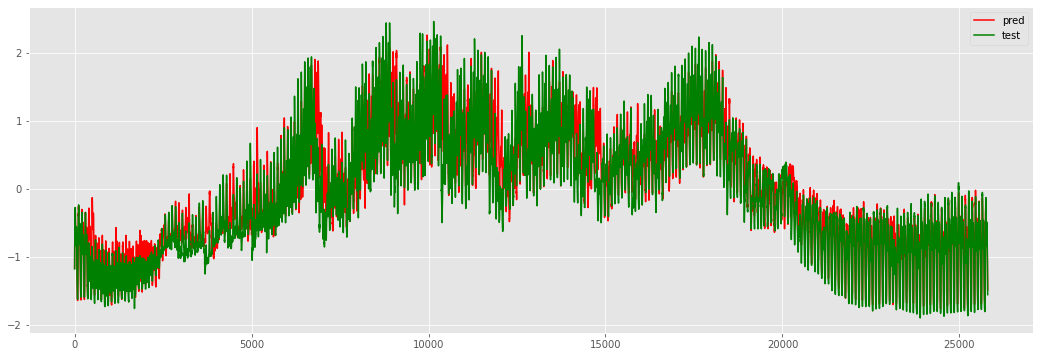

In [43]:
y_pred = reg.predict(X_test)
plt.figure(figsize=(18, 6))
plt.plot(y_pred, color='r', label='pred')
plt.plot(y_test, color='g', label='test')
plt.legend()
plt.show()

In [44]:
y_true = np.array(y_test.iloc[:,0])
sumvalue=np.sum(y_true)
mae = np.mean(np.abs(y_pred - y_true))
print('test MAE:', round(mae,2),'%.')

test MAE: 0.22 %.


## **Conclusion**

you can observe that the test mae of xgboost is far better than the GRU model. So we will proceed with xgboost as our best model

In [46]:
final_model = XGBRegressor(n_estimators=500, learning_rate=0.01)
reg.fit(X_train, 
        y_train,
        eval_set=[(X_train, y_train), (X_val, y_val)],
        eval_metric='mae')

[11:53:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-mae:0.921909	validation_1-mae:0.98794
[1]	validation_0-mae:0.913587	validation_1-mae:0.979044
[2]	validation_0-mae:0.905344	validation_1-mae:0.970227
[3]	validation_0-mae:0.897205	validation_1-mae:0.961514
[4]	validation_0-mae:0.889136	validation_1-mae:0.952897
[5]	validation_0-mae:0.881173	validation_1-mae:0.944375
[6]	validation_0-mae:0.873283	validation_1-mae:0.935939
[7]	validation_0-mae:0.865485	validation_1-mae:0.927599
[8]	validation_0-mae:0.857775	validation_1-mae:0.919344
[9]	validation_0-mae:0.850142	validation_1-mae:0.911156
[10]	validation_0-mae:0.842608	validation_1-mae:0.903085
[11]	validation_0-mae:0.835133	validation_1-mae:0.895098
[12]	validation_0-mae:0.827752	validation_1-mae:0.887179
[13]	validation_0-mae:0.82045	validation_1-mae:0.879368
[14]	validation_0-mae:0.813228	validation_1-mae:0.87163
[15]	validation_0-mae:0.806084	

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.01, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=500,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [48]:
date_indices = list(data_with_load_nan.index)
date_indices = [i-192 for i in date_indices]
dates = list(data_with_load_nan['date'].unique())
indices_12th = list(range(len(data_copy)-96,len(data_copy)))
data_copy.iloc[indices_12th,:].head(2)
date_indices += list(data_copy.iloc[indices_12th,:].index)
dates.append('2020-12-14')
time_stamps = list(data_copy.iloc[0:96,1])
time_stamps = [i[10:] for i in time_stamps]
datetimes = [i+j for i in dates for j in time_stamps]

In [49]:
data_pred = data_copy.iloc[date_indices,[2,4,5,6,7,8]].reset_index(drop=True)
data_pred

,load,temperature,humidity,dew_point,wind_speed,cloud_cover
0,2172.2070,29.68350,0.483000,16.29600,4.462500,0.78750
1,2152.3201,29.70450,0.480375,16.21725,4.215750,0.78750
2,2121.8282,29.72550,0.477750,16.13850,3.969000,0.78750
3,2101.8100,29.74650,0.475125,16.05975,3.722250,0.78750
4,2080.0445,29.76750,0.472500,15.98100,3.475500,0.78750
...,...,...,...,...,...,...
1531,858.5000,17.79750,0.756000,12.40050,1.950375,0.16275
1532,832.2400,17.66100,0.756000,12.26400,2.047500,0.14700
1533,804.9700,17.46675,0.758625,12.12750,2.144625,0.11550
1534,763.5600,17.27250,0.761250,11.99100,2.241750,0.08400


In [50]:
m = data_copy['load'].mean()
s = data_copy['load'].std()
for col in cols:
    data_pred[col] = (np.array(data_pred[col]) - m) / s
data_pred = (data_pred.assign(day_of_week = data_cc_timestamp.dt.dayofweek,
                month = data_cc_timestamp.dt.month, 
                hour = data_cc_timestamp.dt.hour))

In [51]:
forecasts = reg.predict(data_pred)
forecasts = (forecasts*s) + m
Output = pd.DataFrame({'datetime':datetimes, 'forecast':forecasts})

In [52]:
Output

,datetime,forecast
0,2019-05-16 00:00:00,2154.425781
1,2019-05-16 00:15:00,2129.479248
2,2019-05-16 00:30:00,2105.746094
3,2019-05-16 00:45:00,2079.834229
4,2019-05-16 01:00:00,2073.489014
...,...,...
1531,2020-12-14 22:45:00,894.677856
1532,2020-12-14 23:00:00,881.715759
1533,2020-12-14 23:15:00,847.564758
1534,2020-12-14 23:30:00,808.130310
